In [1]:
from grading_tools import check, auto_marking_message
import grading_tools

# Exercises

## Exercise

Check numerically that if $S_t$ is the solution to
$$d S_t = \mu S_t \, d t + \sigma S_t \, d W_t$$
then
$$S_t= S_0 e^{(\mu-\frac{1}{2}\sigma^2)t + \sigma W_t}.$$
This means that you should use the Euler-Maruyama approximation to simulate a solution to
the SDE and plot the result, you should also plot the values of $S_t$ calculated using the second
formula. If you keep refining $W_t$ using Wiener's construction, you should see the two graphs converge
to the same values.

This question is not automatically marked.

In [2]:
import fmlib
import numpy as np
import matplotlib.pyplot as plt
import grading_tools


def simulate_S( S0, mu, sigma, W, t ):
    delta_W = W[1:]-W[0:-1]
    delta_t = t[1:]-t[0:-1]
    S = np.zeros(len(W))
    S[0]=S0
    for i in range(0,len(S)-1):
        S[i+1] = S[i] + S[i]*mu*delta_t[i] \
                   + S[i]*sigma*delta_W[i]
    return S

def analytic_formula( S0, mu, sigma, W, t):
    return S0 *np.exp((mu-0.5*sigma**2)*t + sigma*W)

# Generate a Wiener process
W, t = fmlib.one_step_wiener(1)
for i in range(0,4):
    W, t = fmlib.wiener_interpolate(W,t)

S0 = 2
mu = 0.5
sigma = 1

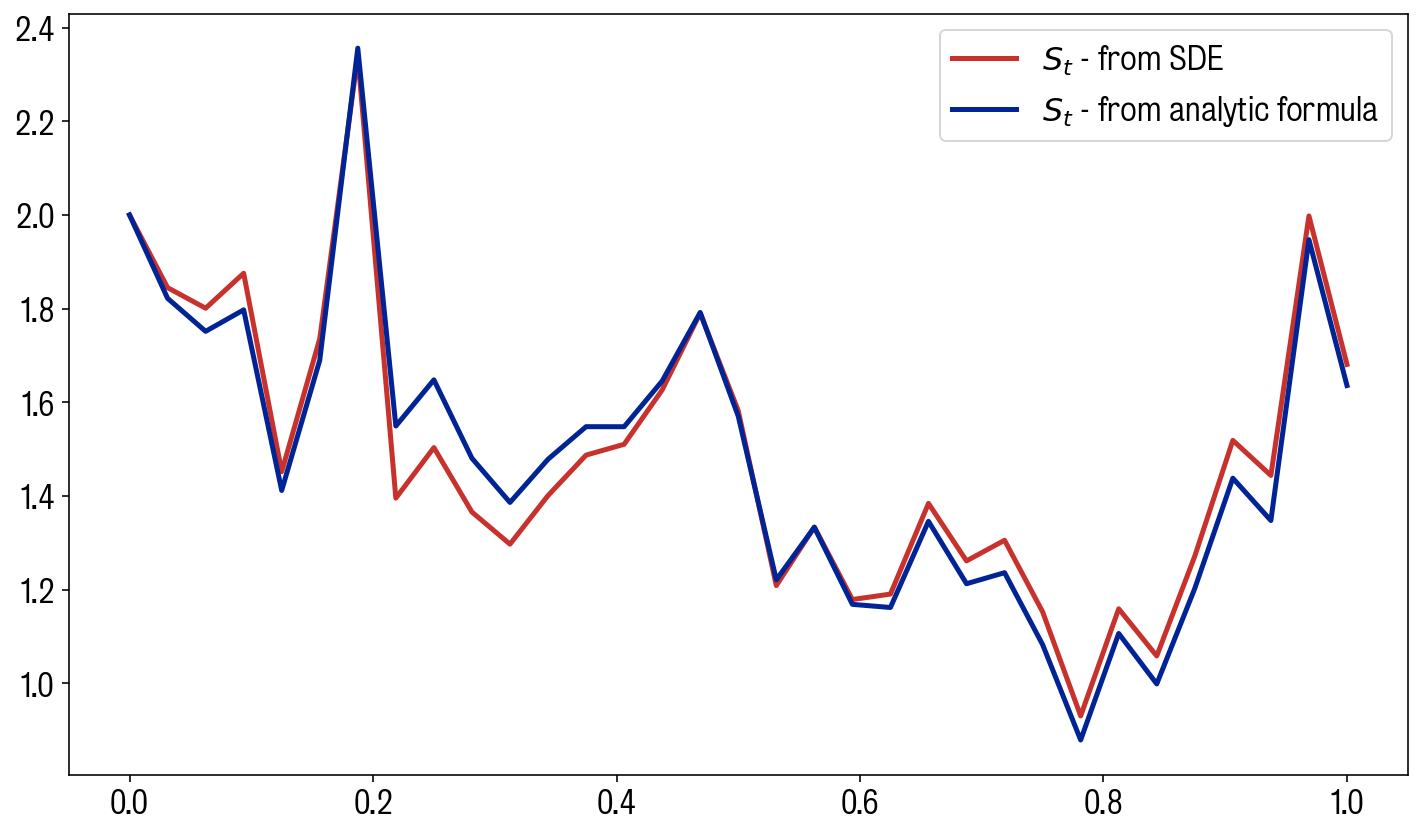

In [3]:
# Run this cell repeatedly to see the convergence
W, t = fmlib.wiener_interpolate(W,t)
S = simulate_S(S0,mu,sigma,W,t)
expected = analytic_formula(S0,mu,sigma,W,t)

ax = plt.gca()
ax.plot(t,S,label='$S_t$ - from SDE');
ax.plot(t,expected,label='$S_t$ - from analytic formula');
ax.legend(); #+


## Exercise

Prove that if $X^{\cal T}_t$ is the Euler-Maruyama approximation to the solution of the SDE
$$
d X_t = a \, dt + b \, dW_t
$$
for constants $a$ and $b$ then
$$
X^{\cal T}_t = X_0 + a t + b W_t.
$$
You can then immediately deduce that the solution to the SDE is
$$
X_t = X_0 + a t + b W_t.
$$

This question is not automatically marked.


### Solution

$$X^{\cal T}_{t+\delta t}:= X^{\cal T}_{t} + a \delta t + b (W_{t+\delta t} - W_t)$$
If we assume as induction hypothesis that
$$
X^{\cal T}_t = X_0 + a t + b W_t.
$$
we find
$$
\begin{split}
X^{\cal T}_{t+\delta t}&= X_0 + a t + b W_t + a \delta t + b (W_{t+\delta t} - W_t)
&= X_0 + a(t + \delta t) + b W_{t+\delta t}.
\end{split}
$$
The result follows by induction.


## Exercise

Plot a fan diagram of the Euler Maruyama approximation to the SDE
$$d S_t = \mu S_t \, d t + \sigma S_t d W_t$$
when $S_0=2$, $\mu=0.5$, $\sigma=1$ on the interval $[0,1]$ using $1024$ steps.

This question is not automatically marked.

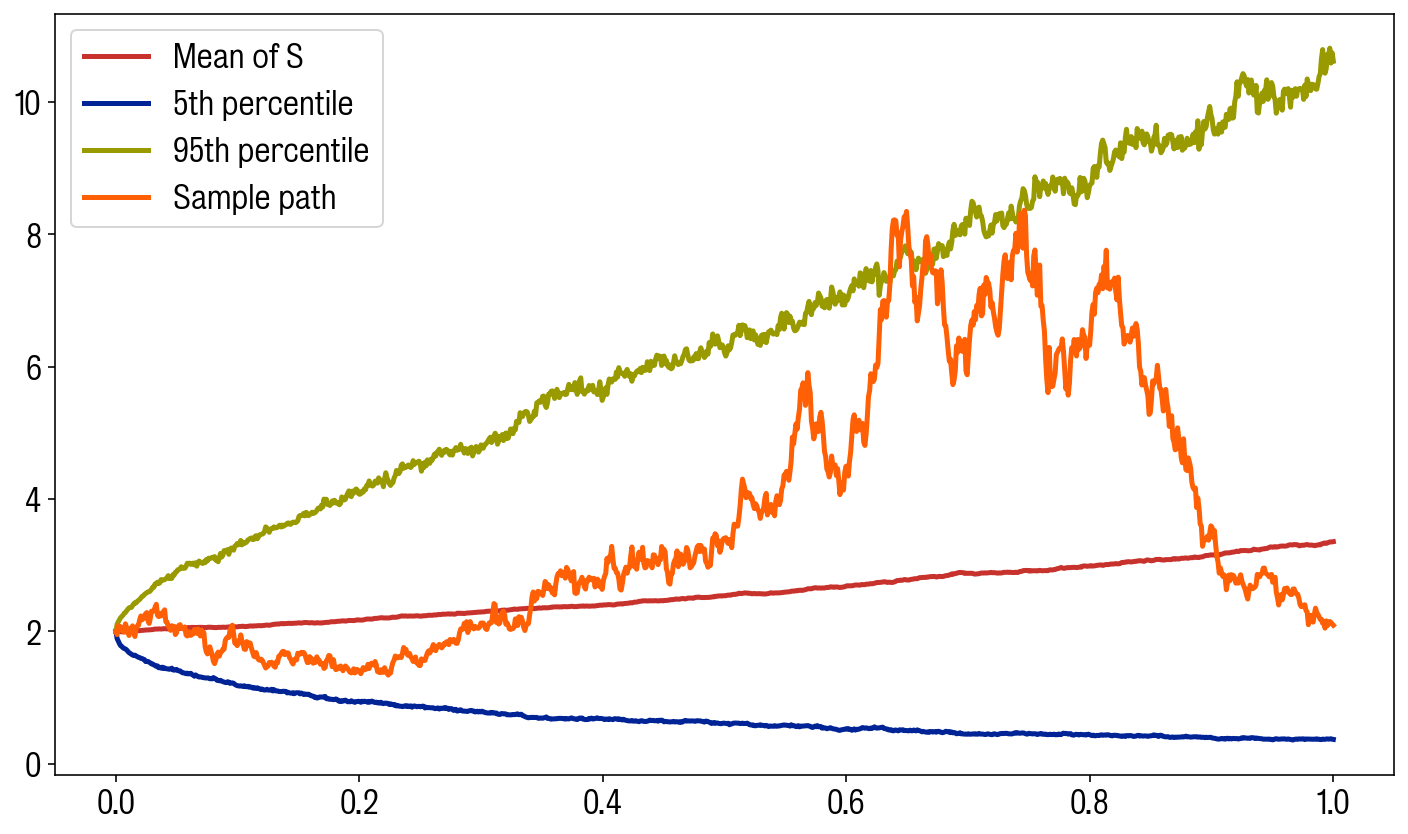

In [4]:
n_simulations = 1000 # Increase for a smooth graph
S = np.zeros((n_simulations,1025))
for i in range(0,n_simulations):
    # Generate a Brownian motion
    W, t = fmlib.one_step_wiener(1)
    for j in range(0,10):
        W, t = fmlib.wiener_interpolate(W,t)
    S[i,:] = simulate_S(S0,mu,sigma,W,t)
    
def fan_plot( t, S, varName='S'):
    ax = plt.gca()
    ax.plot(t, np.mean(S,axis=0),label='Mean of {}'.format(varName))
    ax.plot(t, np.percentile(S,5,axis=0),label='5th percentile' )
    ax.plot(t, np.percentile(S,95,axis=0),label='95th percentile' )
    ax.plot(t, S[0,:],label='Sample path' )
    ax.legend()
    
fan_plot(t,S)

## Exercise

Write a function to compute the Euler Maruyama approximation to the SDE
$$d X_t = a(b-X_t) \, d t + c \, d W_t$$
for constants $a$, $b$ and $c$.

Plot a fan diagram of the resulting process when $X_0=3$, $a=1$, $b=2$ and $c=1$. Read off the 95th percentile of $X_1$ from your plot
and store the value in a variable called `prctile95`.

The solution of this SDE is called an *Ornstein-Uhlenbeck* process. The value of $b$ is called the mean-reversion
level and $a$ is called the speed of mean-reversion. Generate plots that explain this terminology.

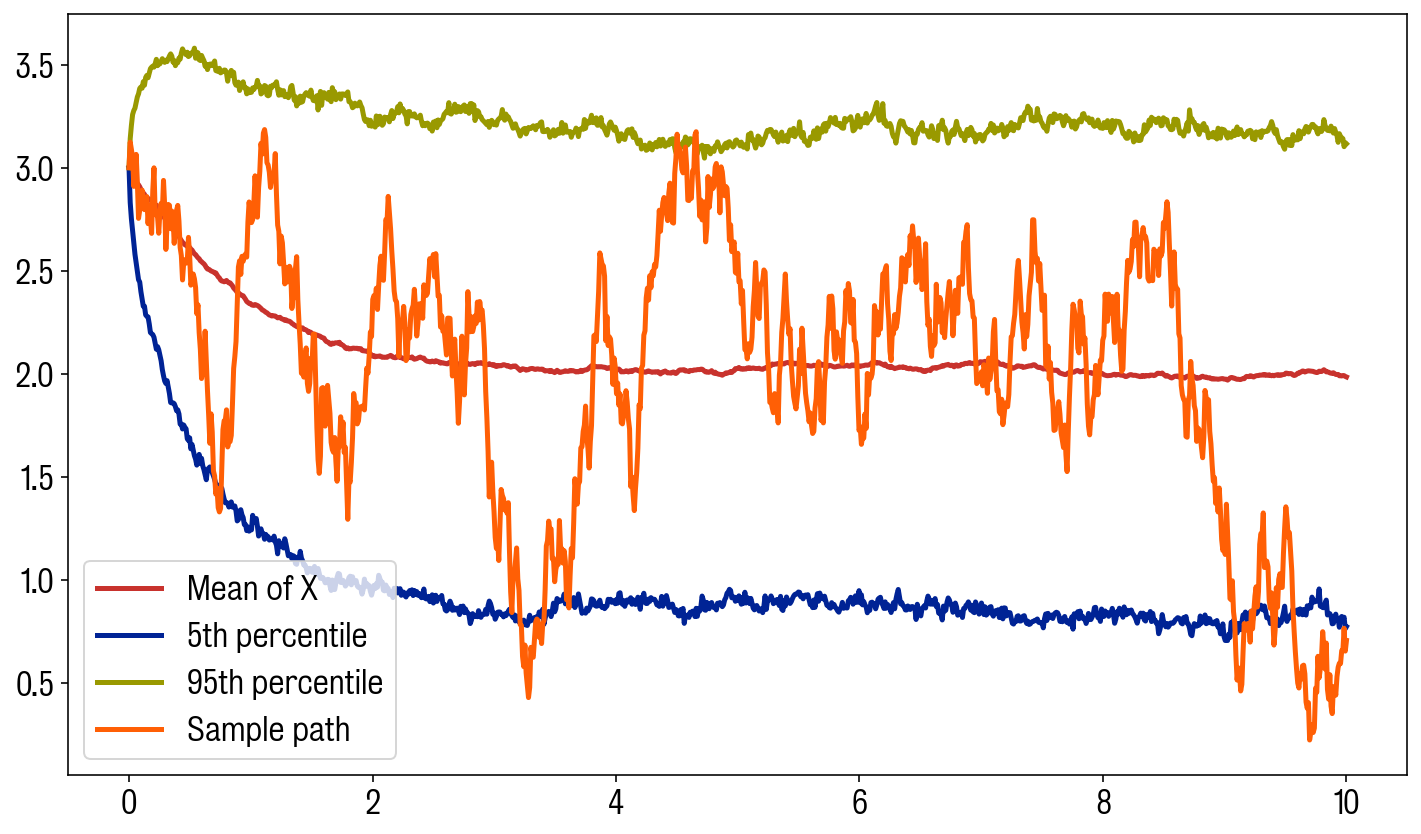

In [5]:
def simulate_X( X0, a, b, c, W, t ):
    delta_W = W[1:]-W[0:-1]
    delta_t = t[1:]-t[0:-1]
    X = np.zeros(len(W))
    X[0]=X0
    for i in range(0,len(W)-1):
        X[i+1] = X[i] + a*(b-X[i])*delta_t[i] \
                   +c*delta_W[i]
    return X

def ornstein_uhlenbeck_fan_plot( X0, a,b,c, T=10, n_simulations=1000):
    log2_steps = 10
    X = np.zeros((n_simulations,2**log2_steps+1))
    for i in range(0,n_simulations):
        # Generate a Brownian motion
        W, t = fmlib.one_step_wiener(T)
        for j in range(0,log2_steps):
            W, t = fmlib.wiener_interpolate(W,t)
        X[i,:] = simulate_X(X0,a,b,c,W,t)
    fan_plot(t,X,'X')

# This plot shows that the process tends to a long term mean of $b=2.0$.
ornstein_uhlenbeck_fan_plot(3,1,2,1)

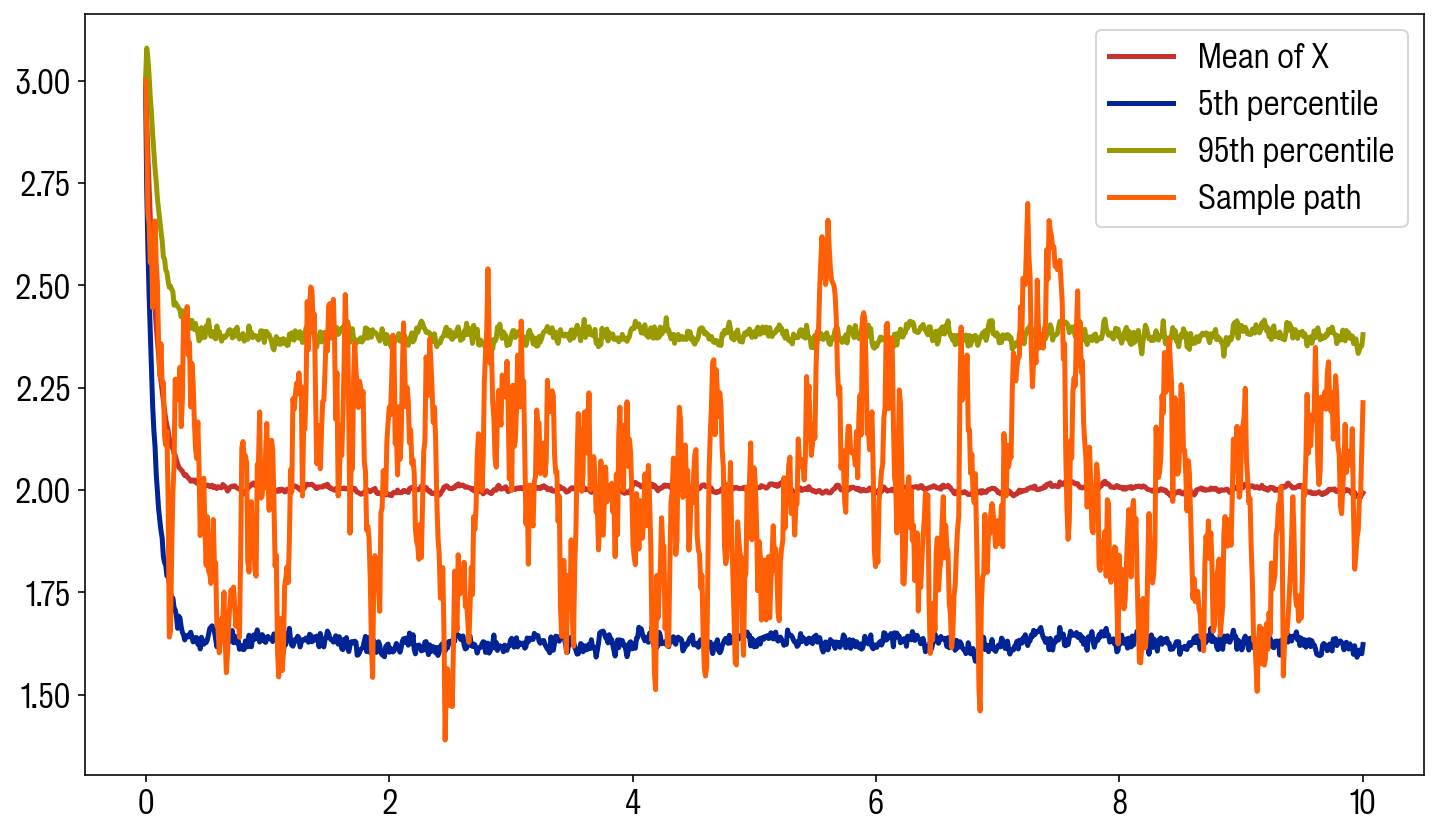

In [6]:
# This plot shows that for large a, the mean reersion is quicker
ornstein_uhlenbeck_fan_plot(3,10,2,1)

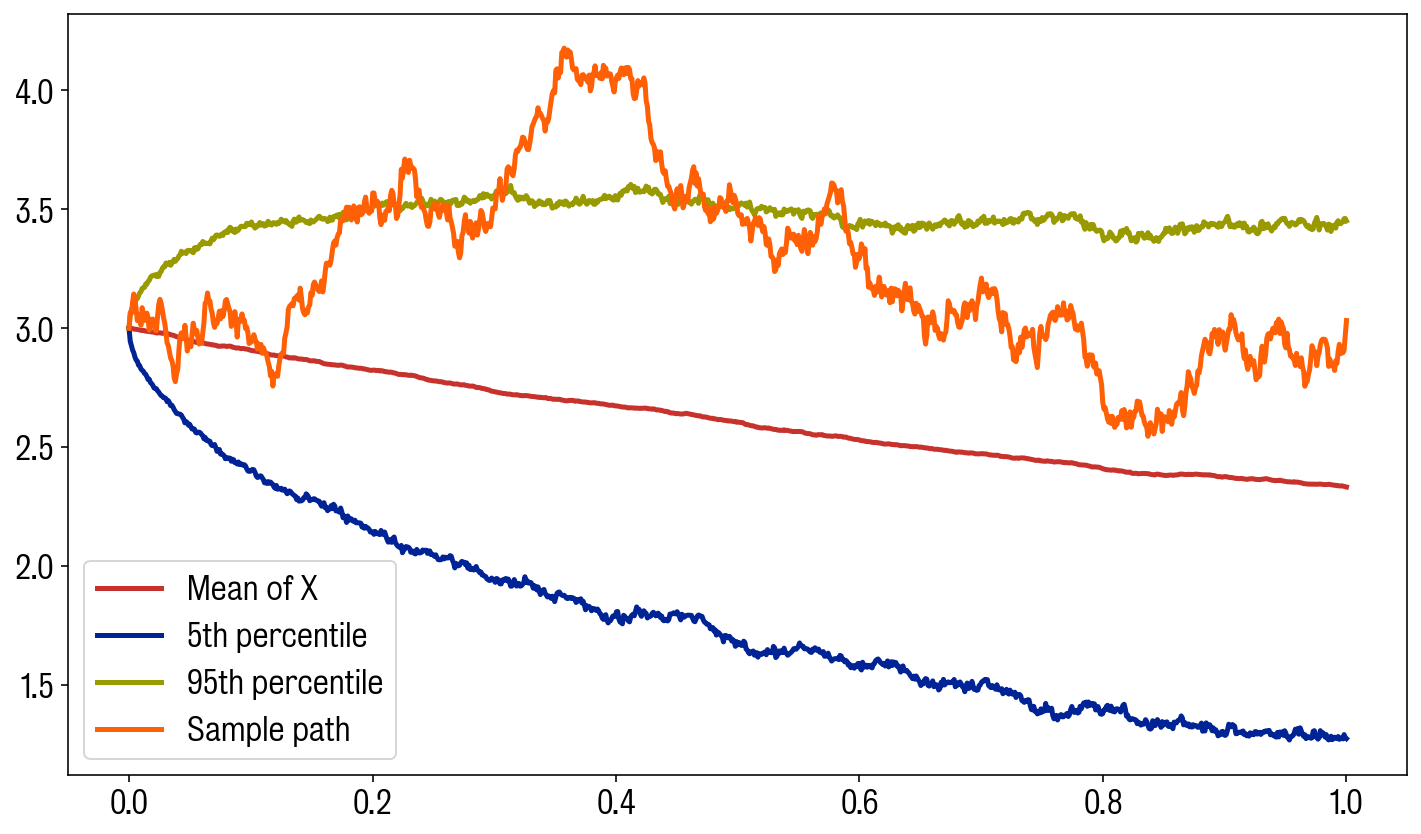

In [7]:
ornstein_uhlenbeck_fan_plot(3,1,2,1,T=1)

In [8]:
prctile95 = 3.5

In [9]:
grading_tools.check('e0a787',prctile95, tol=0.5)
auto_marking_message()

Auto marking message: ✔️ Correct


## Exercise

Suppose that you are interested in simulating the Euler-Maruyama
approximation to $S_t$ on a grid ${\cal T}=\{0,\delta t, 2 \delta t, \ldots \}$
where $S_t$ satisfies
$$
d S_t = \mu S_t dt + \sigma S_t \, d W_t.
$$

Show that you can do this using the difference equation
$$
S_{t+\delta t} = S_t + \mu S_t \delta t  + \sigma S_t \sqrt{\delta t} \, \epsilon_t
$$
where the $\epsilon_t$ are independent standard normal distributions
and so avoid ever computing $W_t$ directly.

This exercise is not automatically marked.

### Solution

By the properties of Brownian motion the increments $W_{t+\delta t}-W_t$ for points $t\in {\cal T}$ are independent
identically distributed normal random variables with variance $\delta t$. Hence we may simulate the values $W_{t-\delta t}-W_t$
using the values $\sqrt{\delta t} \, \epsilon_t$ in which case we will have that the Euler-Maruyama approximation is:
$$
S^{\cal T}_{t+\delta t} = S^{\cal T}_t + \mu S^{\cal T}_t \delta t  + \sigma S^{\cal T}_t \sqrt{\delta t} \, \epsilon_t.
$$

The point is that it is easy enough to simulate $S_t$ at points in a fixed grid ${\cal T}$ without ever needing to think
about Wiener's construction at all. What Wiener's construction allows us to do is refine the grid and prove convergence of the solution
as the grid becomes infinitely fine.